## Exploratory data analysis

In [22]:
import subprocess
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Merge all results into one file.
subprocess.run(["py", "process_data.py", "--merge-results"])

CompletedProcess(args=['py', 'process_data.py', '--merge-results'], returncode=0)

In [24]:
def load_repo_csv(repo_file):
    repo = pd.read_csv(f"data/results/{repo_file}", index_col=0)
    repo['date'] = pd.to_datetime(repo['date'], utc=True)
    return repo

Dataframes for individual repositories.

In [25]:
repo_files = list(set(os.listdir("data/results")) - {"_all_results.csv", "tiny"})

max_repos_load = 5
repos = {repo_file: load_repo_csv(repo_file) for repo_file in repo_files[:max_repos_load]}
repos.keys()

dict_keys(['pick.csv', 'click-default-group.csv', 'Math-Py.csv', 'pydash.csv', 'cached-property.csv'])

Dataframe for all results.

In [26]:
all_results = pd.read_csv("data/results/_all_results.csv", index_col=0)
all_results['date'] = pd.to_datetime(all_results['date'], utc=True)

all_results.shape

(43218, 25)

In [27]:
all_results.head()

,hash,author,date,commit_message,is_merge,lines_changed,insertions,deletions,dmm_unit_size,dmm_unit_complexity,...,radon_avg_cc,radon_avg_MI,radon_avg_vocabulary,radon_avg_length,radon_avg_volume,radon_avg_difficulty,radon_avg_effort,radon_avg_time,radon_avg_bugs,repo_name
ID,,,,,,,,,,,,,,,,,,,,,
0,1c6972eef4d4dc774fa50f29248f776fa6628e9e,Yilei Yang,2017-09-19 21:25:01+00:00,Initial commit: Abseil Python Common Libraries.,False,22843,22843,0,0.544562,0.767955,...,1.956307,65.930709,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
1,e8d3808145a248845098dea839b1ff6753981f18,Yilei Yang,2017-09-25 17:28:32+00:00,Move the --only_check_args check earlier. So ...,False,14,12,2,1.000000,1.000000,...,1.955519,65.918611,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
2,a03c793c3db4d35cac68953c4207e1929881362c,Yilei Yang,2017-09-25 17:29:23+00:00,Fix FLAGS.set_default's docstring. It only se...,False,7,4,3,NaN,NaN,...,1.955519,65.918328,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
3,9b5d766f40f8ff1d2c74c88b95340fdc01a42ef2,Yilei Yang,2017-09-25 17:29:56+00:00,Code cleanup. PiperOrigin-RevId: 169707068,False,5,1,4,NaN,NaN,...,1.955519,65.918655,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
4,99d72774ba05271cf2aa6d9cf80da8508ae48d59,Yilei Yang,2017-09-25 17:31:47+00:00,Clean up unused code. PiperOrigin-RevId: 1697...,False,15,1,14,1.000000,1.000000,...,1.955519,65.919108,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py


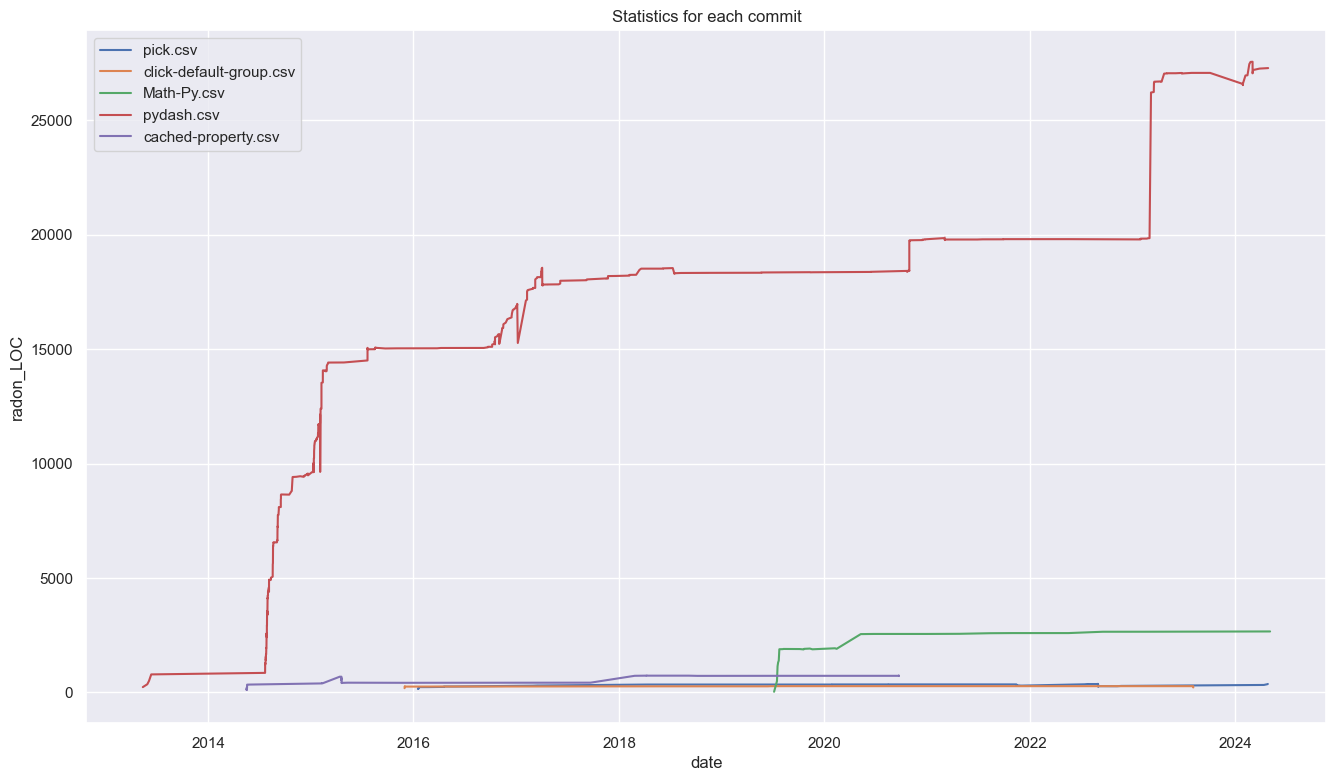

In [28]:
sns.set_theme(rc={'figure.figsize':(16,9)})

# Sample codebase size throughout time.
for repo_name, df in repos.items():
    sns.lineplot(data=df, x='date', y='radon_LOC', label=repo_name)
plt.title("Statistics for each commit");

Shapley analysis.

In [29]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

Mean Squared Error: 3835469.190814024
Mean Absolute Error: 1385.2226681416616
R-squared: 0.9395017563292849


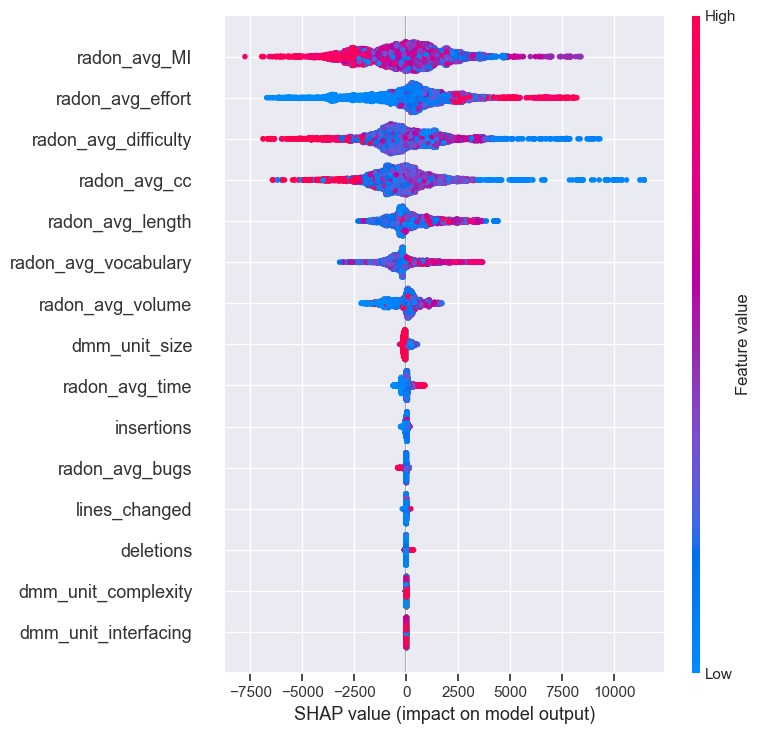

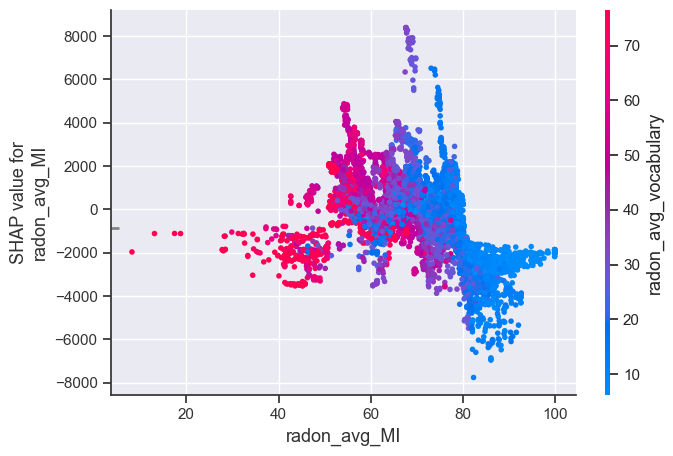

C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


IndexError: tuple index out of range

In [30]:
DATA_FILE = "data/results/_all_results.csv"

data = pd.read_csv(DATA_FILE, usecols=["lines_changed", "insertions", "deletions", "dmm_unit_size", "dmm_unit_complexity", "dmm_unit_interfacing", "radon_LOC", "radon_LLOC", "radon_SLOC", "radon_comments", "radon_avg_cc", "radon_avg_MI", "radon_avg_vocabulary", "radon_avg_length", "radon_avg_volume", "radon_avg_difficulty", "radon_avg_effort", "radon_avg_time", "radon_avg_bugs"])

y = data["radon_LOC"]
X = data.drop(["radon_LOC", "radon_LLOC", "radon_SLOC", "radon_comments"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)

# Hyperparameters for the LightGBM model.
lgbm_params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0
}

model = lgb.train(lgbm_params, train_data, num_boost_round=100)

y_pred = model.predict(X_test)

# Evaluate, show metrics.
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R-squared:", r2)


# Create a SHAP explainer
explainer = shap.Explainer(model)

# Calculate Shapley values for the test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# Plot the Shapley dependence plot for a specific feature
shap.dependence_plot("radon_avg_MI", shap_values, X_test)

# Calculate the Shapley values for a single instance.
instance = X_test.iloc[0]
shap_values_single = explainer.shap_values(instance)

print("Shapley Values for Single Instance:")
print(shap_values_single)

instance = X_test.iloc[4]
shap_values_single = explainer.shap_values(instance)

# Plot the waterfall plot for the 5th element
shap.waterfall_plot(shap.Explanation(values=shap_values_single[0], base_values=model.predict(X_train.mean().values.reshape(1, -1))), max_display=10)

shap.waterfall_plot(shap.Explanation(values=shap_values[1], base_values=explainer.expected_value[1]), feature_names=X_test.columns.tolist(), max_display=10, show=False)


